In [182]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.ndimage.filters import convolve

In [177]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2))) * normal
    return g

In [178]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return (G, theta)

In [180]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180   
    for i in range(1,M-1):
        for j in range(1,N-1):
            q, r = 255, 255
            # angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = img[i, j+1]
                r = img[i, j-1]
            #angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = img[i+1, j-1]
                r = img[i-1, j+1]
            #angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = img[i+1, j]
                r = img[i-1, j]
            #angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = img[i-1, j-1]
                r = img[i+1, j+1]   
            if (img[i,j] >= q) and (img[i,j] >= r):
                Z[i,j] = img[i,j]
            else:
                Z[i,j] = 0    
    return Z

def threshold(img, weak_pixel, strong_pixel, lowThreshold, highThreshold):
    highThreshold = img.max() * highThreshold;
    lowThreshold = highThreshold * lowThreshold;   

    M, N = img.shape

    res = np.zeros((M,N), dtype=np.int32)   

    weak = np.int32(weak_pixel)

    strong = np.int32(strong_pixel)    
    strong_i, strong_j = np.where(img >= highThreshold)

    zeros_i, zeros_j = np.where(img < lowThreshold)  

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak    

    return res

def hysteresis(img, weak_pixel, strong_pixel):
    M, N = img.shape
    weak = weak_pixel
    strong = strong_pixel    
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    
    return img


In [196]:
def candy_edge_detection(img, sigma, kernel_size, weak_pixel, strong_pixel, lowThreshold, highThreshold): 
    img_smoothed = convolve(img, gaussian_kernel(kernel_size, sigma))
    gradientMat, thetaMat = sobel_filters(img_smoothed)
    nonMaxImg = non_max_suppression(gradientMat, thetaMat)
    thresholdImg = threshold(nonMaxImg, weak_pixel, strong_pixel, lowThreshold, highThreshold)

    return hysteresis(thresholdImg, weak_pixel, strong_pixel)
      

In [203]:
def plot_images(input, output):
  fig, axs = plt.subplots(1, 2, figsize=(18, 5))
  fig.suptitle('Original Image, Detected Canny') 
  
  axs[0].imshow(input, 'gray')
  axs[0].set_title('Original image')

  axs[1].imshow(output, 'gray')
  axs[1].set_title('Canny edge detected')

  plt.show()

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [199]:
SIGMA = 1.4
KERNEL_SIZE=5
LOWTHRESHOLD=0.09
HIGHTHRESHOLD=0.17
WEAK_PIXEL=100
STRONG_PIXEL = 255

IMAGES = ['./img/low_contrast.webp', './img/high_contrast.jpeg', './img/low_detailed.jpeg', './img/high_detailed.jpeg']

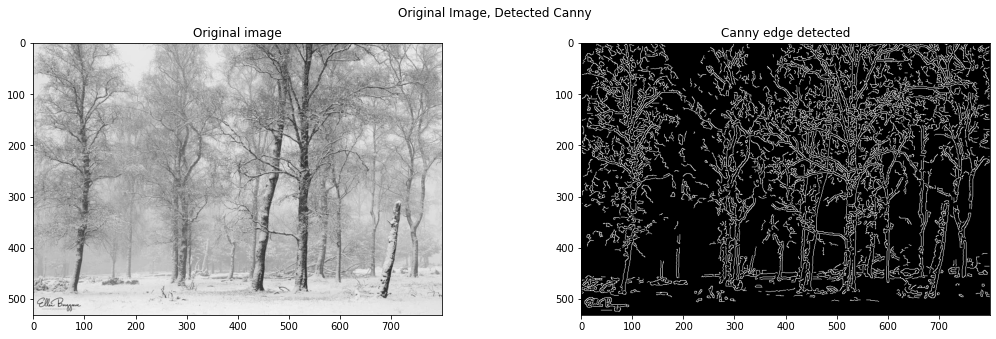

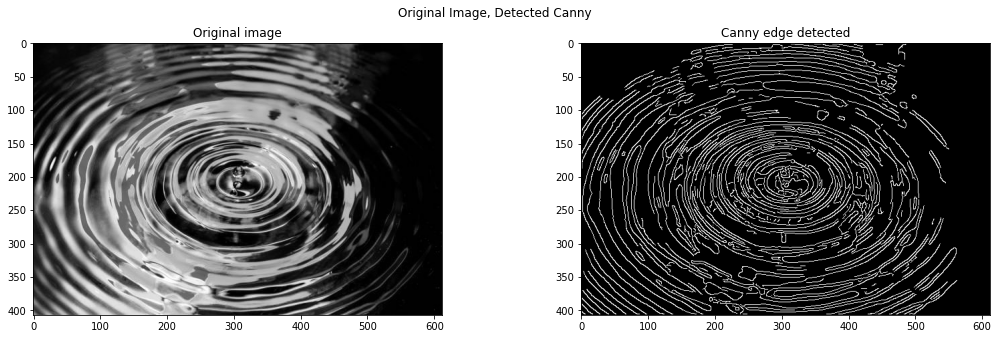

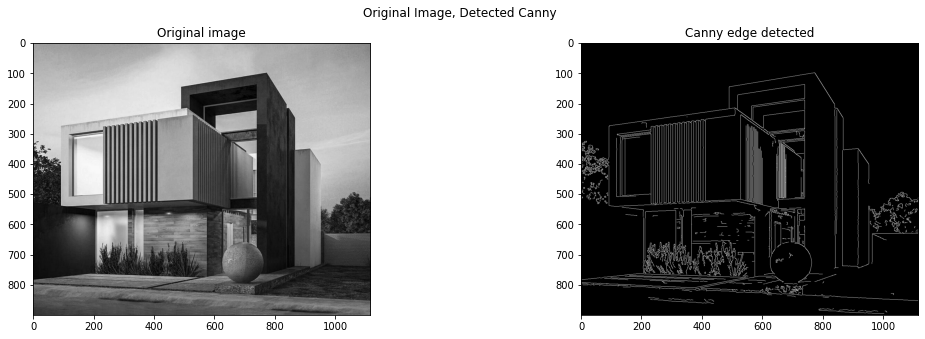

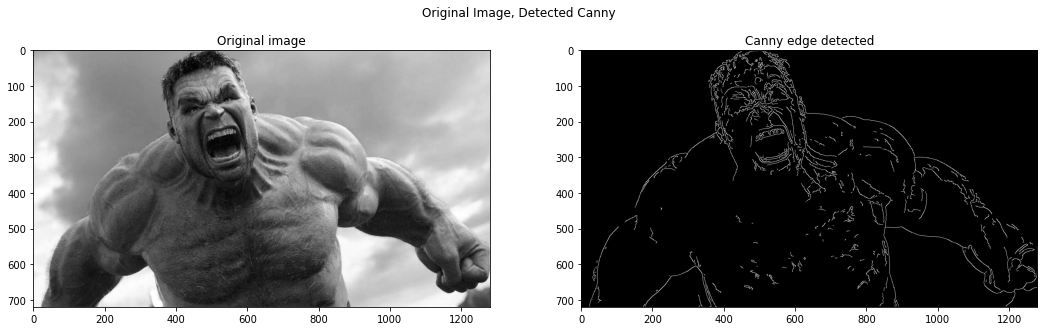

In [204]:
for image_path in IMAGES:
    image = rgb2gray(cv2.imread(image_path))

    image_canny = candy_edge_detection(image, SIGMA, KERNEL_SIZE, WEAK_PIXEL, STRONG_PIXEL, LOWTHRESHOLD, HIGHTHRESHOLD)
    plot_images(image, image_canny)